### EDITING THE GRAPH STATE


In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from langchain_openai import ChatOpenAI
def add(a: int, b: int) -> int:
    """Multiplies two integers.
    Args:
        a (int): The first integer.
        b (int): The second integer."""
    return a + b
def multiply(a: int, b: int) -> int:
    """Multiplies two integers.
    Args:
        a (int): The first integer.
        b (int): The second integer."""
    return a * b
def subtract(a: int, b: int) -> int:
    """Subtracts two integers.
    Args:
        a (int): The first integer.
        b (int): The second integer."""
    return a - b
def divide(a: int, b: int) -> float:
    """Divides two integers.
    Args:
        a (int): The first integer.
        b (int): The second integer."""
    return a / b


llm = ChatOpenAI(model= "gpt-3.5-turbo")
tools = [add, multiply, subtract, divide]
bindedLLM = llm.bind_tools(tools)



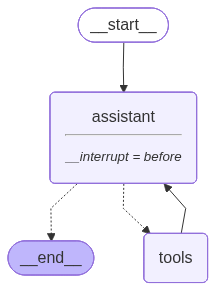

In [3]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [bindedLLM.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
inputMsg = {"messages" : [HumanMessage(content = "What is 3 times 7?")]}

thread = {"configurable" : {"thread_id" : "15"}}

for event in graph.stream(inputMsg, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is 3 times 7?


Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


In [5]:
graphState = graph.get_state(thread)
graphState

StateSnapshot(values={'messages': [HumanMessage(content='What is 3 times 7?', additional_kwargs={}, response_metadata={}, id='5ef2a77b-ab98-4ee1-9fe8-71d70a560296')]}, next=('assistant',), config={'configurable': {'thread_id': '15', 'checkpoint_ns': '', 'checkpoint_id': '1f0fac66-7bae-6892-8000-81d109e56372'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-01-26T14:50:49.925646+00:00', parent_config={'configurable': {'thread_id': '15', 'checkpoint_ns': '', 'checkpoint_id': '1f0fac66-7bac-618e-bfff-b3b23e0ff83e'}}, tasks=(PregelTask(id='0a9eef63-4417-8e2c-8790-8e3d5aeadb81', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [6]:
graph.update_state(thread, {"messages" : [HumanMessage(content="No, Actually multiply 3 times 9")]})


{'configurable': {'thread_id': '15',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0fac6b-fd73-6ea9-8001-17d0d3f0f3c7'}}

In [7]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

No, Actually multiply 3 times 9


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  multiply (call_LIP77zB1Fy9pqbUJ6yRLEeKq)
 Call ID: call_LIP77zB1Fy9pqbUJ6yRLEeKq
  Args:
    a: 3
    b: 9
================================= Tool Message =================================
Name: multiply

27


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


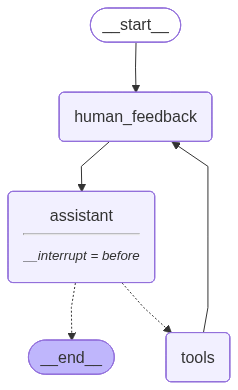

In [8]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

#no-op node
def human_feedback(state : MessagesState):
   pass
# Node
def assistant(state: MessagesState):
   return {"messages": [bindedLLM.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("human_feedback", human_feedback)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
humanGraph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(humanGraph.get_graph(xray=True).draw_mermaid_png()))

In [9]:
input_message = {"messages" : "What is 5 times 2?"}
thread = {"configurable" : {"thread_id" : "17"}}

for event in humanGraph.stream(input_message, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

human_feedback = input("what do you wanna do now?:")

humanGraph.update_state(thread, {"messages" : human_feedback}, as_node="human_feedback")
for event in humanGraph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is 5 times 2?


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================ Human Message =================================

Actually I wanna add 5 and 2


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  add (call_cb5g11I5mSPULQg0bXZ39yhi)
 Call ID: call_cb5g11I5mSPULQg0bXZ39yhi
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: add

7


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
